### Assignment 3.1: Computing densities

In this assignment, you will compute densities from local temperatures and salinities. 

For this, you will need to install the `gsw` package. Assuming you have installed python via anaconda, you can open the anaconda prompt or terminal and type `conda install -n dyoc -c conda-forge gsw`. Then, restart jupyter and import the following packages.

In [1]:
import glob
import gsw
import warnings
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

The data you will be working with was collected on a [cruise with the RRS Discovery](https://www.bodc.ac.uk/data/documents/cruise/8198/) in the Strait of Gibraltar from the 4<sup>th</sup> to 21<sup>st</sup> of April, 1998. The objectives of these cruise were to a) carry out mooring operations, b) study non-linear processes due to strong currents and c) measure biogeochemichal fluxes associated with the upper layer inflow of Atlantic water and the lower layer outflow of Mediterranean water through the Strait.  

Along the cruise trajectory, [27 CTD measurements](https://data-search.nerc.ac.uk/geonetwork/srv/api/records/e7b1b5dadc5a52d18078b9c26f9e08a8) have been taken, sampling temperature, salinity and oxygen levels. The post-processed data is available to you in the folder _RN-9598_1707497532516_, as well as additional reports. You can load the data and plot the trajectory by running the following two cells.

In [2]:
datadir = './'  # change to your directory

# open datasets and sort by time of ctd cast
def decode_time(ds): # needed due to non CF-compliant units
    with warnings.catch_warnings(action='ignore', category=cftime.CFWarning):
        ds['TIME'] = cftime.num2date(ds.TIME, ds.TIME.units)
    return ds

files = glob.glob(f"{datadir}RN-9598_1707497532516/b051*.nc")
data = [decode_time(xr.open_dataset(f, decode_times=False)) for f in files]
data = [data[i] for i in np.argsort([ds.TIME.item() for ds in data])]
print(f"Loaded {len(data)} profiles")

Loaded 27 profiles


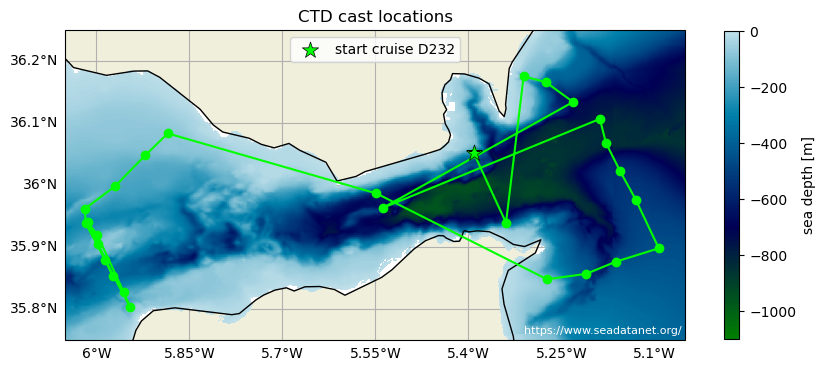

In [3]:
bathy = xr.open_dataset(f"{datadir}bathymetry.nc")
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
tp = ax.pcolormesh(bathy.longitude, bathy.latitude, bathy.elevation, cmap='ocean', vmin=-1100,vmax=100, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.gridlines(draw_labels=['left','bottom'], zorder=0)
ax.plot([ds.LONGITUDE for ds in data], [ds.LATITUDE for ds in data], '-o',
        transform=ccrs.PlateCarree(), c='lime')
ax.scatter(data[0].LONGITUDE, data[0].LATITUDE,c='lime', marker='*', s=150, zorder=2,
           transform=ccrs.PlateCarree(), edgecolors='k', linewidths=.5, label='start cruise D232')
ax.set_title('CTD cast locations')
ax.legend(loc='upper center')
ax.set_extent([-6.05,-5.05,35.75,36.25])
cb = fig.colorbar(tp, ax=ax, shrink=.5)
cb.ax.set_ylim([-1100,0])
cb.set_label('sea depth [m]')
_=ax.text(-5.31,35.76,bathy.infoUrl, c='w', fontsize=8)

In the next assignment, you will analyze the output of CTD cast 517846, taken in the Eastern Mediterranean. First inspect the available data by running the following cell.

In [4]:
data[6]

<xarray.Dataset>
Dimensions:                 (INSTANCE: 1, REFMAX: 3, MAXZ: 395, TIME: 1)
Coordinates:
    LATITUDE                (INSTANCE) float64 36.11
    LONGITUDE               (INSTANCE) float64 -5.188
    PRES                    (INSTANCE, MAXZ) float32 ...
  * TIME                    (TIME) object 1998-04-14 10:25:00.000018
Dimensions without coordinates: INSTANCE, REFMAX, MAXZ
Data variables: (12/16)
    SDN_CRUISE              (INSTANCE) |S80 ...
    crs                     int32 ...
    SDN_EDMO_CODE           (INSTANCE) int32 ...
    SDN_STATION             (INSTANCE) |S80 ...
    SDN_LOCAL_CDI_ID        (INSTANCE) |S80 ...
    SDN_XLINK               (INSTANCE, REFMAX) |S138 ...
    ...                      ...
    DOXYPR01_SEADATANET_QC  (INSTANCE, MAXZ) float32 ...
    DOXYPR01                (INSTANCE, MAXZ) float32 ...
    PSALPR01_SEADATANET_QC  (INSTANCE, MAXZ) float32 ...
    PSALPR01                (INSTANCE, MAXZ) float32 ...
    TEMPST01_SEADATANET_QC  (INSTANCE, MAXZ) float32 ...
    TEMPST01                (INSTANCE, MAXZ) float32 ...
Attributes:
    date_update:  2023-03-11T06:57:14+0000
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  profile
    title:        SeaDataNet NETCDF PROFILE Climate Forecast 1.6 - GENERATED ...

**a)** Write a python programme to plot the density profile of cast 517846 and check whether density increases with depth if a linear equation of state for temperature and salinity is taken. Use:
$$
\rho = \rho_0 \left(1-\alpha_T\left(T-T_0\right)+\beta_S\left(S-S_0\right)\right)
$$
with a reference density $\rho_0 = 1027$ kg m $^{−3}$, thermic expansion coefficient $\alpha_T = 1.0\cdot10^{−4}$ K $^{−1}$, and haline expansion coefficient $\beta_S = 7.0\cdot10^{−4}$. $ T_0 $ and $ S_0 $ are the temperature and salinity closest to the surface respectively.

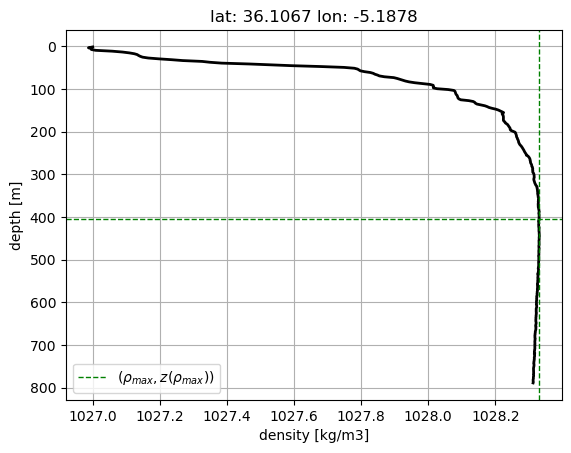

In [5]:
# ANSWER
rho0 = 1027; alpha=1e-4; beta=7e-4
ds = data[6].squeeze()
rho = rho0 * (1- alpha * (ds.TEMPST01-ds.TEMPST01[0]) + beta * (ds.PSALPR01-ds.PSALPR01[0]))
imax = rho.argmax()
plt.figure()
ax = plt.axes()
ax.plot(rho, ds.PRES, lw=2, c='k')
ax.invert_yaxis()
ax.grid()
ax.axhline(ds.PRES[imax], c='g', ls='--', lw=1)
ax.axvline(rho[imax],c='g', ls='--', lw=1, label=r'$(\rho_{max}, z(\rho_{max}))$')
ax.legend()
ax.set_ylabel(f'depth [m]') # assuming 1 dbar = 1 m
ax.set_xlabel('density [kg/m3]')
ax.set_title(f"lat: {ds.LATITUDE.data:} lon: {ds.LONGITUDE.data}")
fig.tight_layout()

**b)** Is the water column stable? Explain.

(Answer) Despite the density decreasing with depth below 400m, the water column is not unstable. The formula used to calculate density in part (a) does not include the effect of compressibility of water. In the upper levels of the ocean the effect of pressure is small and the formula is valid, but in the deeper layers it is no longer negligible.

**c)** As discussed in the lecture, the TEOS10 equations provide more accurate Equations of State. Use the `gsw.conversions.z_from_p()` function to convert the measurement pressures to depths (using the `ds.LATITUDE` value for latitude) and the `gsw.conversions.CT_from_t()` function to convert the in-situ temperature to Conservative Temperature. Then, use the `gsw.density.rho()` function to compute the in-situ density. Use the `help()` function for instructions how to use these functions.

In [6]:
# ANSWER
P = ds.PRES
S = ds.PSALPR01
T = ds.TEMPST01
Z = gsw.conversions.z_from_p(P, ds.LATITUDE)
CT = gsw.conversions.CT_from_t(S, T, P)
Rho = gsw.density.rho(S, CT, P)

**d)** How do the Conservative Temperatures differ from the in-situ temperatures? And how does the density computed form the `gsw` package differ from the density in the equation at a)?

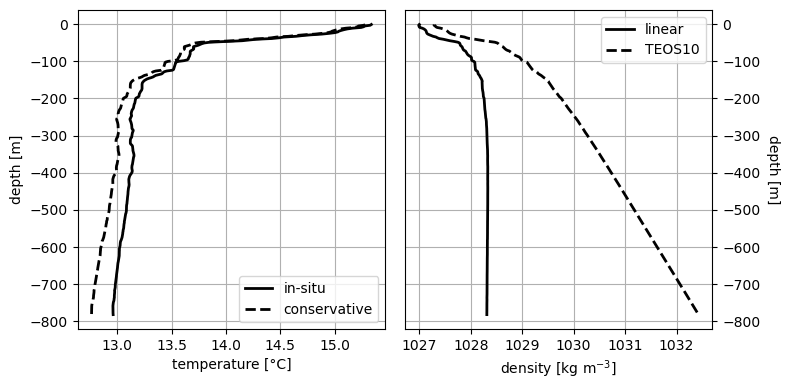

In [7]:
# ANSWER
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.plot(T, Z, 'k-', lw=2, label='in-situ')
ax1.plot(CT, Z, 'k--', lw=2, label='conservative')
ax1.grid()
ax1.set_ylabel('depth [m]')
ax1.set_xlabel('temperature [°C]')
ax1.legend()

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.plot(rho, Z, 'k-', lw=2, label='linear')
ax2.plot(Rho, Z, 'k--', lw=2, label='TEOS10')
ax2.yaxis.label_position = 'right'
ax2.yaxis.tick_right()
ax2.set_ylabel('depth [m]', rotation=270)
ax2.set_xlabel(r'density [kg m$^{-3}$]')
ax2.grid()
ax2.legend()
fig.tight_layout()

The ship made two long sections on the Eastern and Western side of the Strait to measure the biogeochemical fluxes. The cell below shows the track on the Western side.

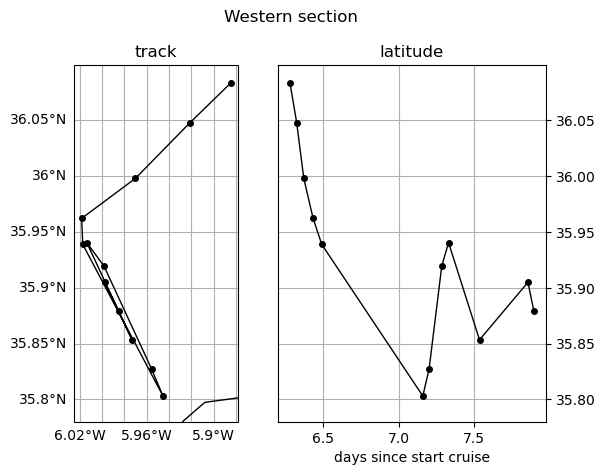

In [8]:
# select western passage and sort by latitude
data_west = [ds for ds in data if ds.LONGITUDE<-5.7]
time = [(ds.TIME.item() - data[0].TIME.item()).total_seconds()/86400 for ds in data_west]

# plot
fig = plt.figure()
ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax.plot([ds.LONGITUDE for ds in data_west], [ds.LATITUDE for ds in data_west], 'k-o',
        lw=1, ms=4, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=['left','bottom'], zorder=0)
ax.set_title('track')
ax.set_ylabel('latitude')
ax.set_ylim([35.78,36.099])

ax2 = fig.add_subplot(122, sharey=ax)
ax2.plot(time, [ds.LATITUDE.item() for ds in data_west], 'k-o', lw=1, ms=4)
ax2.yaxis.label_position = 'right'
ax2.yaxis.set_tick_params(left=False, labelleft=False, right=True, labelright=True)
ax2.yaxis.set_ticks(ax.get_yticks())
ax2.set_yticklabels([t.get_text() for t in ax.get_yticklabels()])
ax2.grid()
ax2.set_title('latitude')
ax2.set_xlabel('days since start cruise')
ax2.set_ylim([35.78,36.099])

fig.suptitle("Western section")
fig.tight_layout()

Apparently the ship did not take the shortest route across the strait. According to the cruise report, the section was split in two parts to give the chemists more time to analyze sample of water in between. However, when they did the second part, three out of seven locations were occupied by fishing boats that they had to steer away from. One data series could still be retrieved the same day, the other two locations were still occupied forcing the crew to do other things and wait. Though there is no need to read the lengthy cruise report yourself, the document is found [here](https://www.bodc.ac.uk/resources/inventories/cruise_inventory/reports/d232.pdf).

Luckily, you do not have to wait for your data today. The following function reads a list of available CTD profiles and combines them into a single array per variable (setting values outside the measured depth interval to NaN). Make sure you understand what it does and plot a 'cross section' (data is projected along the latitude dimension) of temperature and salinity across the Western part of the Strait.  
_Hint: use `plt.pcolormesh()`, which has the option to use linearly interpolated shading._

In [9]:
def crosssection(data, xdim='LATITUDE'):
    """convert data for 'cross section' plot (actually projection along x-axis)

    data : list of DataArray
        list of CTD cast datasets
    xdim : str
        horizontal coordinate in output

    x : 1D horizontal coordinate
    y : 1D vertical coordate (pressure)
    temp : output temperature (y,x)
    salt : output salinity (y,x)
    """
    data = [ds.squeeze() for ds in data]
    data = [data[i] for i in np.argsort([ds[xdim] for ds in data])] # sort by xdim
    x = np.array([ds[xdim].item() for ds in data])
    PMAX = np.max([ds.PRES.max() for ds in data]) # max pressure measured
    y = np.arange(1,PMAX+1,2)
    # below: one-line function taking in dataset and returning variable interpolated to pressures y
    vinterp = lambda ds, var: np.interp(y, ds.PRES, ds[var], left=np.nan, right=np.nan)
    temp = np.array([vinterp(ds, 'TEMPST01') for ds in data]).T
    salt = np.array([vinterp(ds, 'PSALPR01') for ds in data]).T
    return x,y,temp,salt

Text(0.5, 0.98, 'Western Section')

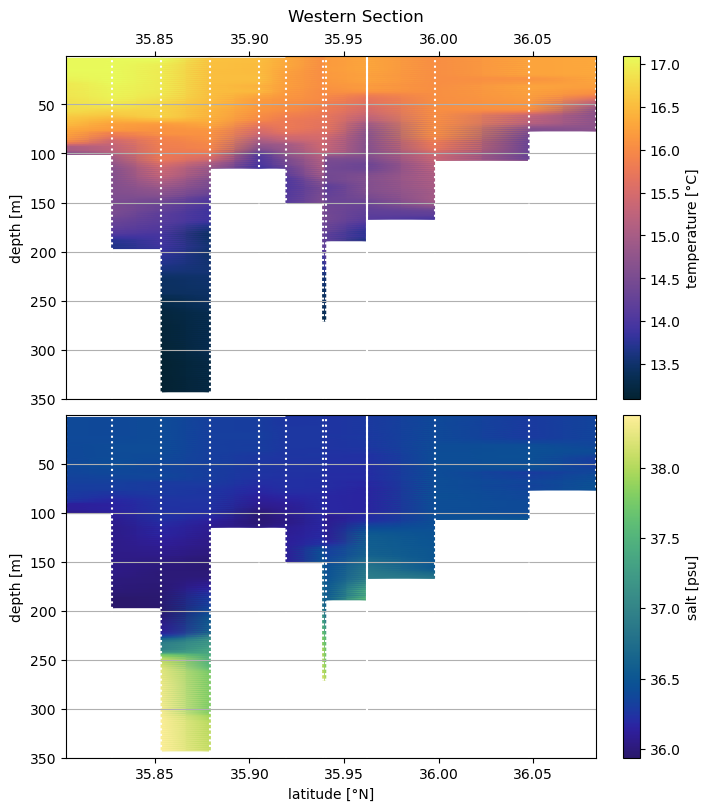

In [10]:
# ANSWER
x,y,temp,salt = crosssection(data_west)

fig = plt.figure(figsize=(7,8), constrained_layout=True)
zmax = 350
ax = fig.add_subplot(211)
p = ax.pcolormesh(x,y,temp,shading='gouraud',cmap=cmocean.cm.thermal)
ax.invert_yaxis()
[ax.axvline(lat,c='w',ls=':') for lat in x] # dotted lines at cast locations
ax.axvline(35.962, c='w', ls='-') # divides two straight sections
cb = fig.colorbar(p, label='temperature [°C]')
ax.set_ylabel('depth [m]')
ax.xaxis.tick_top()
ax.yaxis.grid()
ax.set_ylim([350,1])

ax2 = fig.add_subplot(212, sharex=ax)
p2 = ax2.pcolormesh(x,y,salt, shading='gouraud', cmap=cmocean.cm.haline)
ax2.invert_yaxis()
[ax2.axvline(lat,c='w',ls=':') for lat in x] # dotted lines at cast locations
ax2.axvline(35.962, c='w', ls='-') # divides two straight sections
cb2 = fig.colorbar(p2, label='salt [psu]')
ax2.set_xlabel('latitude [°N]')
ax2.set_ylabel('depth [m]')
ax2.yaxis.grid()
ax2.set_ylim([350,1])
fig.suptitle('Western Section')

Now repeat for the Eastern section (longitude > -5.33). Do you see a pattern corresponding to the exchange of water between the Atlantic Ocean and Mediterranean Sea?

In [11]:
data_east = [ds for ds in data if ds.LONGITUDE>-5.33]

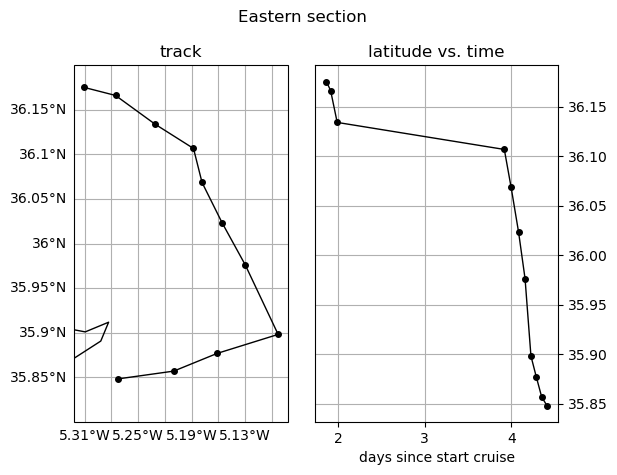

In [12]:
# ANSWER (extra)
# Repeating code for track here, simply for completeness
time_east = [(ds.TIME.item() - data[0].TIME.item()).total_seconds()/86400 for ds in data_east]

fig = plt.figure()
ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax.plot([ds.LONGITUDE for ds in data_east], [ds.LATITUDE for ds in data_east], 'k-o',
        lw=1, ms=4, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=['left','bottom'], zorder=0)
ax.set_title('track')
ax.set_ylabel('latitude')

ax2 = fig.add_subplot(122, sharey=ax)
ax2.plot(time_east, [ds.LATITUDE.item() for ds in data_east], 'k-o', lw=1, ms=4)
ax2.yaxis.label_position = 'right'
ax2.yaxis.set_tick_params(left=False, labelleft=False, right=True, labelright=True)
ax2.yaxis.set_ticks(ax.get_yticks())
ax2.set_yticklabels([t.get_text() for t in ax.get_yticklabels()])
ax2.grid()
ax2.set_title('latitude vs. time')
ax2.set_xlabel('days since start cruise')

fig.suptitle("Eastern section")
fig.tight_layout()

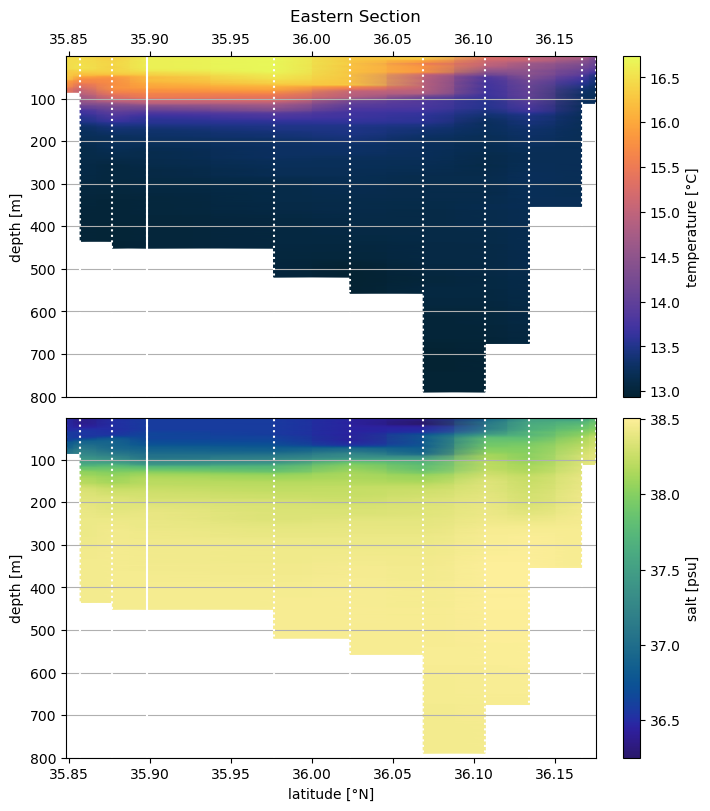

In [13]:
# ANSWER
x,y,temp,salt = crosssection(data_east)

fig = plt.figure(figsize=(7,8), constrained_layout=True)
zmax = 800
ax = fig.add_subplot(211)
p = ax.pcolormesh(x,y,temp,shading='gouraud',cmap=cmocean.cm.thermal)
ax.invert_yaxis()
[ax.axvline(lat,c='w',ls=':') for lat in x] # dotted lines at cast locations
ax.axvline(35.898, c='w', ls='-') # divides two straight sections
cb = fig.colorbar(p, label='temperature [°C]')
ax.set_ylabel('depth [m]')
ax.xaxis.tick_top()
ax.yaxis.grid()
ax.set_ylim([zmax,1])

ax2 = fig.add_subplot(212, sharex=ax)
p2 = ax2.pcolormesh(x,y,salt, shading='gouraud', cmap=cmocean.cm.haline)
ax2.invert_yaxis()
[ax2.axvline(lat,c='w',ls=':') for lat in x] # dotted lines at cast locations
ax2.axvline(35.898, c='w', ls='-') # divides two straight sections
cb2 = fig.colorbar(p2, label='salt [psu]')
ax2.set_xlabel('latitude [°N]')
ax2.set_ylabel('depth [m]')
ax2.yaxis.grid()
ax2.set_ylim([zmax,1])
fig.suptitle('Eastern Section')
plt.show()

Answer: Yes, we see an exchange pattern. On the Western side we see warm and "less-salty" (< 37 psu) Atlantic water on top of colder salty (> 37 psu) water flowing out the Mediterranean. On the Eastern side, the warm and less-salty water flowing in from the Atlantic sits on top of the cold and salty Mediterranean deep water.

The following cell makes a T,S diagram for the linearized equation of state. Add a scatter plot of the density computed from the CTD measurements in the Eastern section and compare your results.

Text(0.5, 1.0, 'Eastern section')

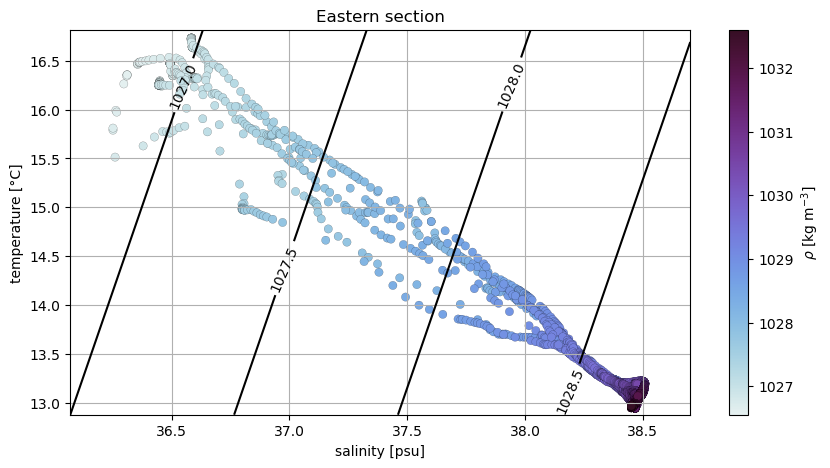

In [14]:
lat,p,temp,salt = crosssection(data_east)

# calculating linearized density RHO
f = 0.005 # add margin around measurements
T = np.linspace(np.nanmin(temp)*(1-f), np.nanmax(temp)*(1+f), len(p))
S = np.linspace(np.nanmin(salt)*(1-f), np.nanmax(salt)*(1+f), len(p))
RHO = rho0 * (1- alpha * (T-T[0])[:,None] + beta * (S-S[0])[None,:])

# plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
CS = ax.contour(S, T, RHO, colors='k', levels=np.arange(1025,1030,0.5))
ax.clabel(CS, inline=1, fontsize=10, fmt='%.1f')
ax.set_xlabel('salinity [psu]')
ax.set_ylabel('temperature [°C]')
ax.grid()

#------------ ANSWER ----------
CT = gsw.CT_from_t(salt, temp, p[:,None])
rho = gsw.rho(salt, CT, p[:,None])
ps = ax.scatter(salt, temp, c=rho, cmap=cmocean.cm.dense, edgecolors='k', linewidths=.1)
fig.colorbar(ps, label=r'$\rho$ [kg m$^{-3}$]')
ax.set_title('Eastern section')
#------------ ANSWER ----------
plt.tight_layout()

Answer: the colors confirm (again) that the linearized equations are a good approximation near the surface only.

Repeat the above plot for the Western section and compare both sections. Explain what you see.

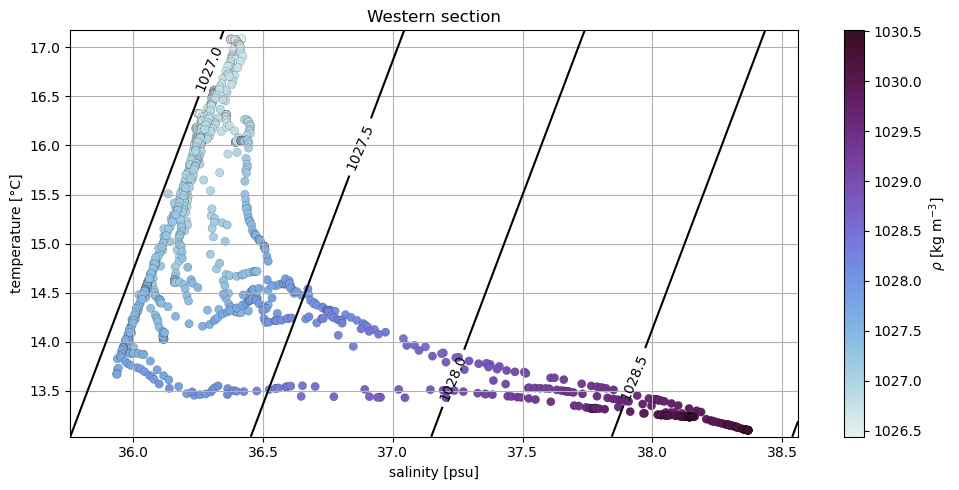

In [15]:
lat,p,temp,salt = crosssection(data_west)

# calculating linearized density RHO
f = 0.005 # add margin around measurements
T = np.linspace(np.nanmin(temp)*(1-f), np.nanmax(temp)*(1+f), len(p))
S = np.linspace(np.nanmin(salt)*(1-f), np.nanmax(salt)*(1+f), len(p))
RHO = rho0 * (1- alpha * (T-T[0])[:,None] + beta * (S-S[0])[None,:])

# plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
CS = ax.contour(S, T, RHO, colors='k', levels=np.arange(1025,1030,0.5))
ax.clabel(CS, inline=1, fontsize=10, fmt='%.1f')
ax.set_xlabel('salinity [psu]')
ax.set_ylabel('temperature [°C]')
ax.grid()

#------------ ANSWER ----------
CT = gsw.CT_from_t(salt, temp, p[:,None])
rho = gsw.rho(salt, CT, p[:,None])
ps = ax.scatter(salt, temp, c=rho, cmap=cmocean.cm.dense, edgecolors='k', linewidths=.1)
fig.colorbar(ps, label=r'$\rho$ [kg m$^{-3}$]')
ax.set_title('Western section')
#------------ ANSWER ----------
plt.tight_layout()

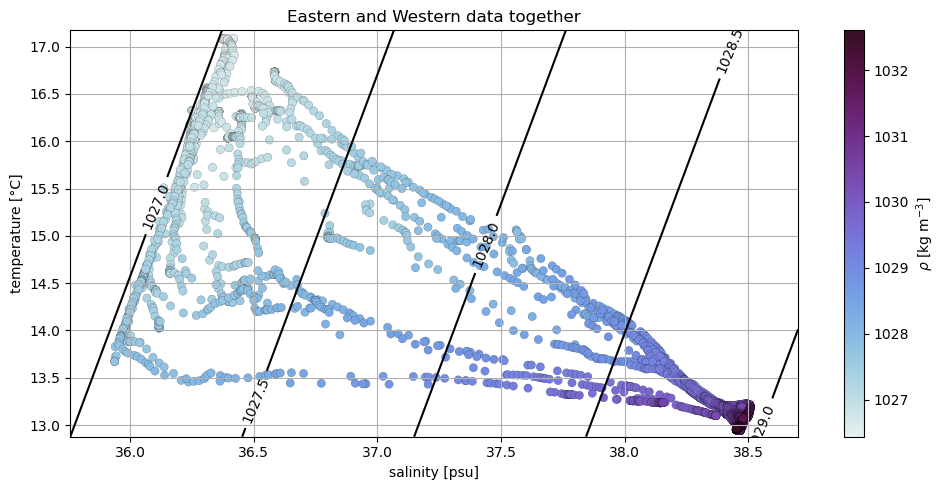

In [16]:
# ANSWER (extra)
# here both sections are plot together for convenience, but the above two plots are sufficient
lat,p,temp,salt = crosssection([*data_west,*data_east])

# calculating linearized density RHO
f = 0.005 # add margin around measurements
T = np.linspace(np.nanmin(temp)*(1-f), np.nanmax(temp)*(1+f), len(p))
S = np.linspace(np.nanmin(salt)*(1-f), np.nanmax(salt)*(1+f), len(p))
RHO = rho0 * (1- alpha * (T-T[0])[:,None] + beta * (S-S[0])[None,:])

# plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
CS = ax.contour(S, T, RHO, colors='k', levels=np.arange(1025,1030,0.5))
ax.clabel(CS, inline=1, fontsize=10, fmt='%.1f')
ax.set_xlabel('salinity [psu]')
ax.set_ylabel('temperature [°C]')
ax.grid()

#------------ ANSWER ----------
CT = gsw.CT_from_t(salt, temp, p[:,None])
rho = gsw.rho(salt, CT, p[:,None])
ps = ax.scatter(salt, temp, c=rho, cmap=cmocean.cm.dense, edgecolors='k', linewidths=.1)
fig.colorbar(ps, label=r'$\rho$ [kg m$^{-3}$]')
ax.set_title('Eastern and Western data together')
#------------ ANSWER ----------
plt.tight_layout()

Answer: The profiles of the Eastern and Western section overlap near the lowest densities (top) and highest densities (bottom-right), indicating these water masses are the same. This is to be expected for the warm water flowing into the Mediterranean and the cold, salty water flowing to the Atlantic. The layers in between have different properties, meaning these water masses are not connected well. This seems to make sense as there has to be a region with no net transport between the layers of inflow and outflow. In this region, water of the same density is generally warmer and saltier in the Mediterranean than the Atlantic. 